In [87]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
os.environ['KAGGLE_CONFIG_DIR'] = '/content/gdrive/My Drive/Kaggle'

filename = 'twitter-and-reddit-sentimental-analysis-dataset.zip'
exfile = 'twiterredditsentimentanalyis'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [88]:
cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [89]:
!kaggle datasets download -d cosmos98/twitter-and-reddit-sentimental-analysis-dataset

twitter-and-reddit-sentimental-analysis-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [90]:
import os
import zipfile as zf

try:
  extFile = zf.ZipFile(filename)
  extFile.extractall(exfile)
  extFile.close()
  print('Dekompresi dataset sukses')
except(FileExistsError,FileNotFoundError):
  print('Tidak dapat melakukan decompresi dataset')
finally:
  print('Operation terminated')

Dekompresi dataset sukses
Operation terminated


In [91]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

vocabSize = 5000
maxlength = 100
testSize = 0.2
embeddedDim = 64
batchSize = 128
trunc_type = 'post'
padding_type = 'post'
oovTok = '<OOV>'
files = os.listdir(exfile)
datasetFiles = os.path.join(exfile,files[1])
print('file dataset {}'.format(datasetFiles))

file dataset twiterredditsentimentanalyis/Twitter_Data.csv


In [92]:
import json as js
import pandas as pd
normalizationDataset = pd.read_csv(datasetFiles)
normalizationDataset.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [93]:
review = normalizationDataset['clean_text']
rating = []

for r in normalizationDataset['category']:
  if r == -1.0:
    rating.append('negative')
  if r == 0.0:
    rating.append('neutral')
  if r == 1.0:
    rating.append('positive')

  if r != -1.0 and r != 0.0 and r != 1.0:
    rating.append('negative')

normalizationDataset = pd.DataFrame({'tweet':review,'category':rating})
normalizationDataset.head()

,tweet,category
0,when modi promised “minimum government maximum...,negative
1,talk all the nonsense and continue all the dra...,neutral
2,what did just say vote for modi welcome bjp t...,positive
3,asking his supporters prefix chowkidar their n...,positive
4,answer who among these the most powerful world...,positive


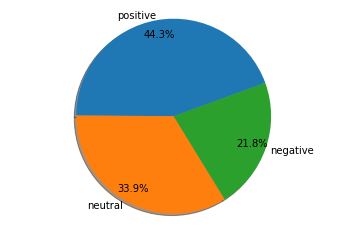

total sample dataset: 162980 unit


In [94]:
import matplotlib.pyplot as plt

sizes = normalizationDataset.category.value_counts().values
labels = normalizationDataset.category.value_counts().index

plt.pie(
    sizes,
    labels=labels,
    autopct='%.1f%%',
    shadow=True,
    pctdistance=0.85,
    labeldistance=1.05,
    startangle=20,
    explode = [0 if 1 > 0 else 0.2 for i in range(len(sizes))])

plt.axis('equal')
plt.show()
print('total sample dataset: {} unit'.format(sum(sizes)))


In [95]:
normalizationDataset.shape

(162980, 2)

In [96]:
normalizationDataset.category.value_counts()

positive    72250
neutral     55213
negative    35517
Name: category, dtype: int64

In [97]:
lenDataset = normalizationDataset.groupby('category')
classQty = lenDataset.ngroups
print('total class {}'.format(classQty))
category = lenDataset['category']
category = category
lenDataset.size()


total class 3


category
negative    35517
neutral     55213
positive    72250
dtype: int64

In [98]:
normalizationDataset.head()

,tweet,category
0,when modi promised “minimum government maximum...,negative
1,talk all the nonsense and continue all the dra...,neutral
2,what did just say vote for modi welcome bjp t...,positive
3,asking his supporters prefix chowkidar their n...,positive
4,answer who among these the most powerful world...,positive


In [99]:
#mormalization dataset
import re

def cleanLowerCase(textDataset):
  return str(textDataset).lower()

normalizationDataset['tweet'] = normalizationDataset['tweet'].apply(cleanLowerCase)
normalizationDataset['category'] = normalizationDataset['category'].apply(cleanLowerCase)

normalizationDataset.head()

,tweet,category
0,when modi promised “minimum government maximum...,negative
1,talk all the nonsense and continue all the dra...,neutral
2,what did just say vote for modi welcome bjp t...,positive
3,asking his supporters prefix chowkidar their n...,positive
4,answer who among these the most powerful world...,positive


In [100]:
labelCollm = normalizationDataset.category
labelCollm = labelCollm.unique()
print('Class {}'.format(labelCollm))

Class ['negative' 'neutral' 'positive']


In [101]:
category = pd.get_dummies(normalizationDataset.category)
hotEncodingDataset = pd.concat([normalizationDataset,category],axis=1)
hotEncodingDataset = hotEncodingDataset.drop(columns='category')
hotEncodingDataset.head()

,tweet,negative,neutral,positive
0,when modi promised “minimum government maximum...,1,0,0
1,talk all the nonsense and continue all the dra...,0,1,0
2,what did just say vote for modi welcome bjp t...,0,0,1
3,asking his supporters prefix chowkidar their n...,0,0,1
4,answer who among these the most powerful world...,0,0,1


In [64]:
hotEncodingDataset.shape

(162980, 4)

In [102]:
#Data split
dataHeadlineDescription = hotEncodingDataset['tweet'].values
label = hotEncodingDataset[labelCollm].values
dataHeadlineDescription_train,dataHeadlineDescription_test,label_train,label_test = train_test_split(dataHeadlineDescription,label,test_size=testSize)
print('Training Shape {}'.format(dataHeadlineDescription_train.shape))
print('Training Test shape  {}'.format(dataHeadlineDescription_test.shape))
print('Training label shape {}'.format(label_train.shape))
print('test label shape {}'.format(label_test.shape))

Training Shape (130384,)
Training Test shape  (32596,)
Training label shape (130384, 3)
test label shape (32596, 3)


In [103]:
#Tokenizer 
tokenizer = Tokenizer(num_words=vocabSize,oov_token=oovTok)


tokenizer.fit_on_texts(dataHeadlineDescription_train)
tokenizer.fit_on_texts(dataHeadlineDescription_test)

trainSequences = tokenizer.texts_to_sequences(dataHeadlineDescription_train)
testSequences = tokenizer.texts_to_sequences(dataHeadlineDescription_test)


trainPadded = pad_sequences(
                            trainSequences,
                            maxlen=maxlength,
                            padding=padding_type,
                            truncating=trunc_type
    )
testpadded = pad_sequences(
                           testSequences,
                           maxlen=maxlength,
                           padding=padding_type,
                           truncating=trunc_type
    )

idx = len(tokenizer.word_index)
print('{} unique token'.format(idx))

113680 unique token


In [104]:
print('training Padding shape {}'.format(trainPadded.shape))
print('test Padding shape {}'.format(testpadded.shape))

training Padding shape (130384, 100)
test Padding shape (32596, 100)


In [114]:
#Creating Model
from tensorflow import keras
from tensorflow.keras.layers import Embedding,Dense,Conv1D,LSTM,Flatten,GlobalAveragePooling1D,Bidirectional,Dropout
from tensorflow.keras.optimizers import Adam



model = keras.models.Sequential()
model.add(Embedding(idx+1,embeddedDim,input_length=maxlength))
model.add(Bidirectional(LSTM(100,return_sequences=True)))
model.add(Bidirectional(LSTM(100,return_sequences=True)))
model.add(Bidirectional(LSTM(64,return_sequences=True)))
model.add(Bidirectional(LSTM(32)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1024,activation='relu'))
model.add(Dense(embeddedDim,activation='relu'))
model.add(Dense(3,activation='softmax'))

optimizer = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 100, 64)           7275584   
_________________________________________________________________
bidirectional_32 (Bidirectio (None, 100, 200)          132000    
_________________________________________________________________
bidirectional_33 (Bidirectio (None, 100, 200)          240800    
_________________________________________________________________
bidirectional_34 (Bidirectio (None, 100, 128)          135680    
_________________________________________________________________
bidirectional_35 (Bidirectio (None, 64)                41216     
_________________________________________________________________
flatten_8 (Flatten)          (None, 64)                0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)               

In [118]:
#Fit model

ACC_TRESHOLD = 0.96
class Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
    if (logs.get('accuracy') > ACC_TRESHOLD):     
      print('\n{}% accuracy reached,end the Training\n'.format(ACC_TRESHOLD*100))
      print('\nActual accuracy {}%\n'.format(logs.get('accuracy')*100))
      self.model.stop_training = True
     
checkpoint_filepath = '/tmp/NLPTwiter/checkpoint/TwiterModelSentimentAnalisis/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='accuracy',
    mode='max',
    save_best_only=True)
saveLog =  tf.keras.callbacks.CSVLogger('/tmp/NLPTwiter/trainingTwiterLog.csv',separator=',',append=True)

callbackStop = Callback()

with tf.device('/device:GPU:0'):
  history = model.fit(
    trainPadded,
    label_train,
    epochs=100,
    validation_data = (testpadded,label_test),
    steps_per_epoch=100,
    batch_size = batchSize,
    use_multiprocessing=True,
    validation_steps=50,
    callbacks=[callbackStop,model_checkpoint_callback,saveLog]
    )
  
  model.save('/tmp/NLPTwiter/CategoryModel_3ClassTwiter.h5')
  print('\nTraining Selesai')

Epoch 1/100
100/100 [==============================] - 15s 149ms/step - loss: 0.9330 - accuracy: 0.5591 - val_loss: 0.7489 - val_accuracy: 0.6722
Epoch 2/100
100/100 [==============================] - 13s 127ms/step - loss: 0.6021 - accuracy: 0.7534 - val_loss: 0.5380 - val_accuracy: 0.7950
Epoch 3/100
100/100 [==============================] - 13s 128ms/step - loss: 0.4730 - accuracy: 0.8295 - val_loss: 0.4348 - val_accuracy: 0.8508
Epoch 4/100
100/100 [==============================] - 13s 128ms/step - loss: 0.3951 - accuracy: 0.8745 - val_loss: 0.3845 - val_accuracy: 0.8778
Epoch 5/100
100/100 [==============================] - 13s 127ms/step - loss: 0.3439 - accuracy: 0.8905 - val_loss: 0.3656 - val_accuracy: 0.8861
Epoch 6/100
100/100 [==============================] - 13s 127ms/step - loss: 0.3116 - accuracy: 0.9000 - val_loss: 0.3129 - val_accuracy: 0.8944
Epoch 7/100
100/100 [==============================] - 13s 127ms/step - loss: 0.3016 - accuracy: 0.9037 - val_loss: 0.3079 -

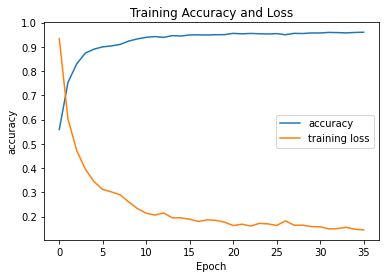

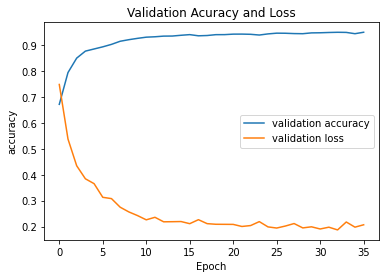

In [119]:
#plotting
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epoch = range(len(acc))

plt.plot(epoch,acc,label='accuracy')
plt.plot(epoch,loss,label='training loss')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Training Accuracy and Loss')
plt.legend()
plt.show()
plt.plot(epoch,val_acc,label='validation accuracy')
plt.plot(epoch,val_loss,label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Validation Acuracy and Loss')
plt.legend()
plt.show()

In [125]:
def Predict(textPredict):
  paddedtext = pad_sequences(tokenizer.texts_to_sequences([textPredict]),maxlen=maxlength,truncating=trunc_type,padding=padding_type)

  prediction = model.predict(paddedtext,batch_size=batchSize)
  label_encoder = preprocessing.LabelEncoder()

  if (prediction[0,0] > prediction[0,1]) and (prediction[0,0] > prediction[0,2]):
    idx_p = 0
  elif (prediction[0,1] > prediction[0,0]) and (prediction[0,1] > prediction[0,2]):
    idx_p = 1
  elif (prediction[0,2] > prediction[0,0]) and (prediction[0,2] > prediction[0,1]):
    idx_p = 2
  print('\nTweet: {}'.format(textPredict))
  print('Sentiment : {} \n'.format(labelCollm[idx_p]))

In [126]:
#Prediction
from sklearn import preprocessing
text_1 = 'answer who among these the most powerful world i been seen'
text_2 = 'whats its is so bad i does want it its a trast phone'
text_3 = 'not bad this phone pretty good'
text_4 = 'hi buddy you looks so handsome i like you babe'
Predict(text_1)
Predict(text_2)
Predict(text_3)
Predict(text_4)


Tweet: answer who among these the most powerful world i been seen
Sentiment : positive 


Tweet: whats its is so bad i does want it its a trast phone
Sentiment : negative 


Tweet: not bad this phone pretty good
Sentiment : positive 


Tweet: hi buddy you looks so handsome i like you babe
Sentiment : neutral 

